# Analytical virtual metrics (NO SWAPS)

In [17]:
import numpy as np
import numpy.matlib as npm
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import rc
import copy
import warnings
import scipy
from scipy import sparse
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdmn
import importlib as imp
import os
import random

import main_cd as main
import main_analytical as ma

# Dark background?
dark = False
if dark==True:
    plt.style.use('dark_background')
else:
    plt.style.use('default')
    
# Latex
from matplotlib import rc
plt.rcParams['font.family'] = 'Arial'
#rc('text', usetex=True)
#plt.rcParams.update({
#    'text.usetex': True,
#    'text.latex.preamble': r'\usepackage{amsfonts}'
#})

# Save figures in the notebook with decent quality
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

# Create figures directory if needed
try:
    os.mkdir('figs')
except FileExistsError:
    pass

<br />
<br />

---

# Analytical results

---

<br />
<br />

In [27]:
# Inputs
physical_degree = 5
p_gen_vec = [0.01,0.2,0.5,0.8,0.99]
p_cons_vec = np.linspace(0,1,200)
cutoff_times_pcons = 10
qbits_per_channel = 10

# Figure specs
x_cm = 8
y_cm = 5
fontsize = 8
save = True

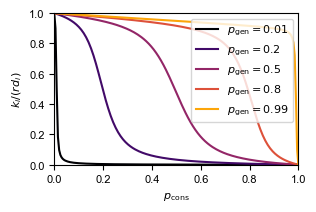

In [28]:
imp.reload(ma)

max_p_cons = max(p_cons_vec)
min_cutoff = cutoff_times_pcons/max_p_cons
assert qbits_per_channel <= min_cutoff, 'cutoff should be larger than qbits_per_channel'

## CREATE FIGURE ##
fig, ax = plt.subplots(figsize=(x_cm/2.54, y_cm/2.54)) 
cmap = plt.colormaps.get_cmap('inferno')
colors = [cmap(x) for x in np.linspace(0,0.8,len(p_gen_vec))]

gamma_is_r = True
gamma_is_cutoff = True
for idx, p_gen in enumerate(p_gen_vec):
    ## COMPUTE ##
    vneighs_vec = []
    vdeg_vec = []
    for p_cons in p_cons_vec:
        if p_cons == 0:
            cutoff = 10000
        else:
            cutoff = cutoff_times_pcons/p_cons
        gamma = min(cutoff,qbits_per_channel)
        vneighs, vdeg = ma.virtual_ss_noswaps(physical_degree, p_gen, p_cons,
                            cutoff, qbits_per_channel)
        vneighs_vec += [vneighs]
        vdeg_vec += [vdeg]
        if cutoff < qbits_per_channel:
            gamma_is_r = False
        if cutoff > qbits_per_channel:
            gamma_is_cutoff = False

    ## PLOT ##
    plt.plot(p_cons_vec, np.array(vdeg_vec)/physical_degree/gamma,
             color=colors[idx],
             label=r'$p_\mathrm{gen}=%s$'%p_gen)
    
## PLOT SPECS ##
plt.legend(fontsize=fontsize, loc='upper right')
plt.xlabel(r'$p_\mathrm{cons}$', fontsize=fontsize)
if gamma_is_r:
    plt.ylabel(r'$k_i / (r d_i)$', fontsize=fontsize)
elif gamma_is_cutoff:
    plt.ylabel(r'$k_i / (t_\mathrm{cut} d_i)$', fontsize=fontsize)
else:
    plt.ylabel(r'$k_i / (\gamma d_i)$', fontsize=fontsize)
#ax.set_yticks([0,1])
ax.tick_params(axis='both', which='major', labelsize=fontsize)
plt.xlim(0,1)
plt.ylim(0,1)

if save:
    filename = 'figs/THEORY_NOSWAPS_avg_vdegrees_physdeg%d'\
                '-cutoff_times_pcons%s-qbits_per_channel%d.pdf'%(physical_degree,
                                                 cutoff_times_pcons, qbits_per_channel)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
else:
    plt.show()

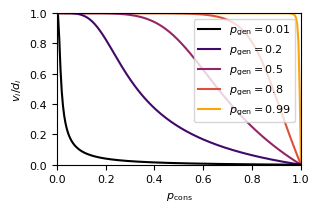

In [34]:
imp.reload(ma)

## CREATE FIGURE ##
x_cm = 8
y_cm = 5
fig, ax = plt.subplots(figsize=(x_cm/2.54, y_cm/2.54))
cmap = plt.colormaps.get_cmap('inferno')
colors = [cmap(x) for x in np.linspace(0,0.8,len(p_gen_vec))]

for idx, p_gen in enumerate(p_gen_vec):
    ## COMPUTE ##
    vneighs_vec = []
    vdeg_vec = []
    for p_cons in p_cons_vec:
        if p_cons == 0:
            cutoff = 10000
        else:
            cutoff = cutoff_times_pcons/p_cons
        gamma = min(cutoff,qbits_per_channel)
        vneighs, vdeg = ma.virtual_ss_noswaps(physical_degree, p_gen, p_cons,
                            cutoff, qbits_per_channel)
        vneighs_vec += [vneighs]
        vdeg_vec += [vdeg]

    ## PLOT ##
    plt.plot(p_cons_vec, np.array(vneighs_vec)/physical_degree,
             color=colors[idx],
             label=r'$p_\mathrm{gen}=%s$'%p_gen,
             zorder=-idx)
    
## PLOT SPECS ##
plt.legend(fontsize=fontsize, loc='upper right')
plt.xlabel(r'$p_\mathrm{cons}$', fontsize=fontsize)
plt.ylabel(r'$v_i / d_i$', fontsize=fontsize)
#ax.set_yticks([0,1])
ax.tick_params(axis='both', which='major', labelsize=fontsize)
plt.xlim(0,1)
plt.ylim(0,1)

if save:
    filename = 'figs/THEORY_NOSWAPS_avg_vneighs_physdeg%d'\
                '-cutoff_times_pcons%s-qbits_per_channel%d.pdf'%(physical_degree,
                                                 cutoff_times_pcons, qbits_per_channel)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
else:
    plt.show()

<br />
<br />

---

# Convergence of simulation to analytical steady state

---

<br />
<br />

For the simulation below, we use a tree network. However, in the absence of swaps any network topology will give the same results.

In [35]:
imp.reload(main)

# Topology
protocol = 'srs'
d = 2
k = 3
n = int(str(d)+str(k)) # This variable is only for data storage purposes
A = main.adjacency_tree(d,k)
topology = 'tree'

# Hardware
p_gen = 0.2
p_swap = 1 # Irrelevant
qbits_per_channel = 5
coherence_time = 2000

# Software/application
max_links_swapped = 3 # Irrelevant
p_cons = 0.1
F_app = 0.6

# CD protocol
q_swap = 0

# Cutoff calculation
F_new = 1-p_gen/2
cutoff = np.floor( -coherence_time * np.log(3*(
            (4*F_app-1)/3)**(1/max_links_swapped)/(4*F_new-1)) )
print('cutoff =',cutoff)


# Simulation
data_type = 'avg'
N_samples = 10000 #10000
total_time = cutoff*2 #*10
window = 10
randomseed = 2
np.random.seed(randomseed)

# Plot
users = [0,1,2] # Nodes that we want to look at: root, branch (lvl 1), and leaf (lvl 2)
user_phys_degs = [2,3,1]
varying_array = np.append( np.arange(0,0.5,0.01), np.arange(0.5,1.01,0.05) )
varying_param = 'q_swap'

# Figure specs
x_cm = 8
y_cm = 5
fontsize = 8

cutoff = 221.0


Maximum std: 0.869
Maximum standard error: 0.017


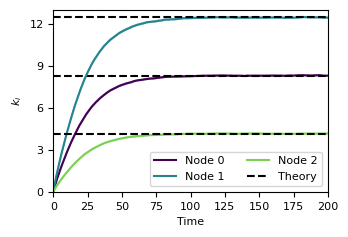

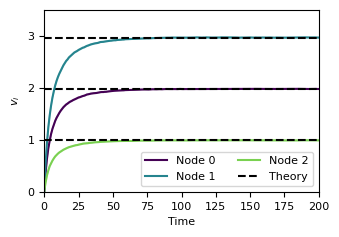

In [60]:
imp.reload(main)

### ANALYTICAL ###
avg_vdegs_theory = []
avg_vneighs_theory = []
gamma = min(cutoff,qbits_per_channel)
for physical_degree in user_phys_degs:
    avg_vdeg, avg_vneigh, _, _ = main.theory_virtual_noswaps(physical_degree, p_gen, p_cons,
                                                cutoff, qbits_per_channel)
    avg_vneighs_theory += [avg_vneigh]
    avg_vdegs_theory += [avg_vdeg]
    
### SIMULATION ###
main.plot_avgs(users, protocol, data_type, topology, n, p_gen,
                q_swap, p_swap, p_cons, cutoff, max_links_swapped,
                qbits_per_channel, N_samples, total_time, randomseed,
                avg_vdegs_theory=avg_vdegs_theory, avg_vneighs_theory=avg_vneighs_theory,
                physical_degrees=user_phys_degs, steady_state_window=None,
                dark=False, legend='nodes', save=True, xlimits=[0,200],
                x_cm=9, y_cm=6,
                ylimits_deg=[0,13], num_y_ticks_vdeg=5,
                ylimits_neigh=[0,3.5], num_y_ticks_vneigh=4)